In [7]:
import pandas as pd
from haversine import haversine
import numpy as np
from numpy.linalg import norm
import folium
from folium.plugins import MarkerCluster
import math
import networkx as nx

In [2]:
railroad_lines = pd.read_csv("out.csv", low_memory = False)

In [3]:
crossings_latest = pd.read_csv("CI_Crossings.csv", encoding='latin1', error_bad_lines=False, low_memory =False) 

b'Skipping line 160681: expected 181 fields, saw 196\nSkipping line 283207: expected 181 fields, saw 246\nSkipping line 376480: expected 181 fields, saw 256\nSkipping line 390634: expected 181 fields, saw 182\nSkipping line 396649: expected 181 fields, saw 294\n'


In [4]:
crossings_latest_clean = crossings_latest[crossings_latest.Latitude > 0]
crossings_latest_clean = crossings_latest_clean[(crossings_latest_clean.DayThru + crossings_latest_clean.NghtThru) > 0]

In [ ]:
for index, row in railroad_lines.iterrows():
    row["STCYFIPS"] = int(row["STCYFIPS"])
    
segment_to_crossing = {}
segment_to_crossing_count = {}
crossing_to_segment = {}

for crossing_index, crossing_row in crossings_latest_clean.iterrows():
    
    mindist = float("inf")
    min_segment = ""
    
    crossing_lat_long = np.array([float(crossing_row["Latitude"]), float(crossing_row["Longitude"])])
    crossing_object_id = crossing_row["CrossingID"]
    
    crossing_county = int(crossing_row["CntyCD"].lstrip("0"))
    railroad_lines_for_county = railroad_lines[railroad_lines.STCYFIPS == crossing_county]
    
    for lines_index, lines_row in railroad_lines_for_county.iterrows():
        coord_list = []
        start = lines_row["start"]
        start_coords = np.array([float(start.split(",")[1]),float(start.split(",")[0])])
        
        end = lines_row["end"]
        end_coords = np.array([float(end.split(",")[1]),float(end.split(",")[0])])
        
        intermediates = lines_row["internmediate"]
        try:
            if ";" in intermediates:
                intermediate_coords = intermediates.split(";")
            else:
                intermediate_coords = [intermediates]
        except TypeError:
            intermediate_coords = []
        
        if len(intermediate_coords) > 0:
            middle = intermediate_coords[int(len(intermediate_coords)/2)]
            middle_coord = np.array([float(middle.split(",")[1]),float(middle.split(",")[0])])
        
        dist1 = haversine(start_coords, crossing_lat_long)
        dist2 = haversine(end_coords, crossing_lat_long)
        min_of_the_two = min(dist1, dist2)
        
        if len(intermediate_coords) > 0:
            dist3 = haversine(middle_coord, crossing_lat_long)
            min_of_the_two = min(min_of_the_two, dist3)
            
        if min_of_the_two < mindist:
            mindist = min_of_the_two
            min_segment = lines_row["OBJECTID"]
                
    
    crossing_to_segment[crossing_object_id] = min_segment
    try:
        segment_to_crossing_count[min_segment] += 1
    except KeyError:
        segment_to_crossing_count[min_segment] = 1
    
    try:
        segment_to_crossing[min_segment].append(crossing_object_id)
    except KeyError:
        segment_to_crossing[min_segment] = [crossing_object_id]

In [144]:
G=nx.MultiGraph()
for index, row in railroad_lines.iterrows():
    G.add_edge(row["start"], row["end"], weight = float(row["MILES"]), key=row["OBJECTID"])

In [145]:
src = "-72.624948810747753,41.938546918291664"
tgt = "-73.089256413411732,41.317474504919659"
p = nx.dijkstra_path(G, source=src, target=tgt)

In [147]:
US_center = [39.8283, -98.5795]
my_map = folium.Map(location = US_center, zoom_start = 4)

segments_on_shortest_path = []
all_points = []
i = 0
while i < len(p) - 1:
    node = railroad_lines[railroad_lines["start"] == p[i]]
    node = node[node["end"] == p[i + 1]]
    node = node[node["MILES"] == node["MILES"].min()]
    flip = False
    if len(node) > 1:
        node = node.loc[[0]]
    elif len(node) == 0:
        node = railroad_lines[railroad_lines["end"] == p[i]]
        node = node[node["start"] == p[i + 1]]
        node = node[node["MILES"] == node["MILES"].min()]
        flip = True
    
    node.internmediate.fillna("")
    
    for index, row in node.iterrows():
        segments_on_shortest_path.append(row["OBJECTID"])
        if flip == True:
            end = row["start"]
            start = row["end"]
        else:
            start = row["start"]
            end = row["end"]
        intermediates = row["internmediate"]

        try:
            if ";" in intermediates:
                intermediate_coords = intermediates.split(";")
            else:
                intermediate_coords = [intermediates]
        except TypeError:
            intermediate_coords = []
            
        
        
        coords = []
        coords.append(float(start.split(",")[1]))
        coords.append(float(start.split(",")[0]))
        all_points.append(coords)
        
        if flip == True:
            intermediate_coords.reverse()

        for intermediate_coord in intermediate_coords:
            coords = []
            coords.append(float(intermediate_coord.split(",")[1]))
            coords.append(float(intermediate_coord.split(",")[0]))
            all_points.append(coords)
        
        coords = []
        coords.append(float(end.split(",")[1]))
        coords.append(float(end.split(",")[0]))
        all_points.append(coords)
    i += 1
    
coords = []
coords.append(float(src.split(",")[1]))
coords.append(float(src.split(",")[0]))
folium.Marker(coords, popup = "source").add_to(my_map)

coords = []
coords.append(float(tgt.split(",")[1]))
coords.append(float(tgt.split(",")[0]))
folium.Marker(coords, popup = "destination").add_to(my_map)

folium.PolyLine(all_points, color="red", weight=4.0, opacity=1).add_to(my_map)

In [148]:
from folium.features import CustomIcon

url = 'https://d30y9cdsu7xlg0.cloudfront.net/png/{}'.format
icon_image = url('701-200.png')
icon = CustomIcon("https://images-na.ssl-images-amazon.com/images/I/61tjlbWX%2BDL._SY463_.jpg", icon_size=(38, 95), icon_anchor = (22,94))

for segment in segments_on_shortest_path:
    try:
        for crossing in segment_to_crossing[segment]:
            crossing_row = crossings_latest_CT_clean[crossings_latest_CT_clean["CrossingID"] == crossing]
            for index, row in crossing_row.iterrows():
                coords = []
                coords.append(row["Latitude"])
                coords.append(row["Longitude"])
                folium.Marker(coords, popup = "crossing").add_to(my_map)
    except KeyError:
           continue

In [149]:
my_map

In [151]:
import collections
CT_segment_to_crossing_count = collections.OrderedDict()
crossing_to_freq = collections.OrderedDict()
segment_to_crossing
for segment_id in segments_on_shortest_path:
    try:
        crossings = segment_to_crossing[segment_id]
        print(len(crossings))
        for crossing in crossings:
            crossing_row = crossings_latest_CT_clean[crossings_latest_CT_clean.CrossingID == crossing]
            frequency_of_crossings = crossing_row.iloc[0].DayThru + crossing_row.iloc[0].NghtThru
            crossing_to_freq[crossing] = frequency_of_crossings
        #break
        #CT_segment_to_crossing_count[segment_id] = segment_to_crossing_count[segment_id]
    except KeyError:
        pass

1
2
5
2
2
1
1
2
1
1
3
1
4
6
1
1
5
1


In [156]:
crossings_list = []
crossing_freq_list = []

for K, V in crossing_to_freq.items():
    #print(V)
    crossings_list.append(K)
    crossing_freq_list.append(V)

#segment_list = list(CT_segment_to_crossing_count.keys())

crossings_to_plot = pd.DataFrame(crossings_list, columns=['Segment'])

crossing_freq_Series = pd.Series(crossing_freq_list)
#crossings_to_plot.assign(Segment=segment_list)
crossings_to_plot["Frequency of crossings"] = crossing_freq_Series

In [157]:
crossings_to_plot

,Segment,Frequency of crossings
0,500747H,14.0
1,500745U,14.0
2,500746B,14.0
3,500731L,14.0
4,500734G,14.0
5,500739R,14.0
6,500741S,14.0
7,973100R,14.0
8,500727W,14.0
9,500729K,14.0


In [160]:
import seaborn as sb
import matplotlib.pyplot as plt
graph = sb.pointplot(data=crossings_to_plot,x="Segment",y="Frequency of crossings")
graph.set_title("Windsor Locks, CT - Shelton, CT",size=12)
graph.set_xlabel("Segments",size=10)
graph.set_ylabel("Frequency of crossings",size=10)
plt.xticks(rotation=45)
plt.setp(graph.collections, sizes=[8])

[None]

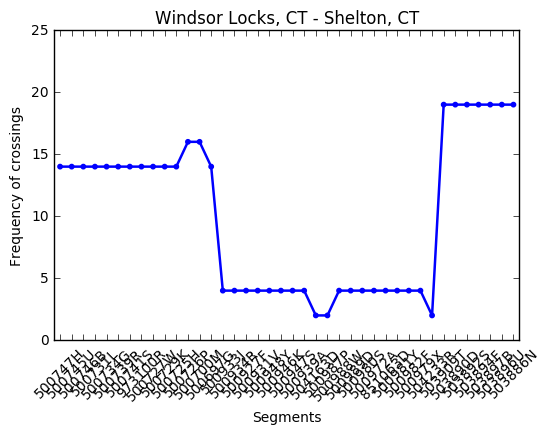

In [161]:
plt.show()